<h1 align="center"> Image Captioning </h1>

Итак, мы сейчас займемся image captioning =)
![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели каритнку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всегоработают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/iK9ZtggjJcGKIA)

### Базовая часть:
1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания так, как мы любим. Ну, токенизация там (да, в 100500-ый раз, только теперь сами)
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса (тренировать и генерировать веса -- это оч долго, поверьте мне). 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### Вариативная часть:
Что еще можно сделать:
1. Нагуглить другой датасет (в MSCOCO видны паттерны -- все тексты выглядят как "хто-то с чем-то что-то делает")
2. Взять не Inseption-v3, а другую предобученную сеть
3. Запилить аттеншен во второй сети (не, ну а вдруг)
4. Написать бота ))0))
5. Whatever comes to your head

## Базовая часть:

### 1. Предобработка текстов из датасета

In [1]:
import sys
import os

from tqdm.notebook import tqdm as tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import IPython
import ipywidgets

import time

DATA_PATH = os.path.abspath('data')
DATA_PATH

'C:\\pscripts\\nlp\\image_captioning\\data'

In [2]:
import requests
import random

def download_file(url, path):
    r = requests.get(url, allow_redirects=True)
    with open(path, 'wb') as f:
        f.write(r.content)
        
def make_learnable(model, learnable):
    for param in model.parameters():
        param.requires_grad = learnable

SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)

In [3]:
%%time
import numpy as np
import json

# загружаем датасет
img_codes = np.load(os.path.join(DATA_PATH, 'image_codes.npy'))
captions = json.load(open(os.path.join(DATA_PATH, 'captions_tokenized.json')))

Wall time: 763 ms


Получим расширенные анотации, чтобы в будущем сопоставить с картинками

In [4]:
%%time
import zipfile
if not os.path.exists(os.path.join(DATA_PATH, 'annotations.zip')):
    download_file('http://images.cocodataset.org/annotations/annotations_trainval2017.zip',
                  os.path.join(DATA_PATH, 'annotations.zip'))

if not os.path.exists(os.path.join(DATA_PATH, 'annotations/captions_train2017.json')):
    with zipfile.ZipFile(os.path.join(DATA_PATH, 'annotations.zip'), 'r') as zip_ref:
        zip_ref.extract('annotations/captions_train2017.json', path=DATA_PATH)
        
annotations_data = json.load(open(os.path.join(DATA_PATH, 'annotations/captions_train2017.json')))

annotations_data.keys()

Wall time: 743 ms


dict_keys(['info', 'licenses', 'images', 'annotations'])

In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Misha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Загрузим аннотации, сопоставим их по номеру в массиве с предзагруженными описаниями и эмбеддингами картинок

In [6]:
%%time

annotations = []
annot_captions = {}

tokenizer = nltk.WordPunctTokenizer()

def remove_spaces(s):
    if type(s) is list:
        return list(map(remove_spaces, s))
    return ''.join(s.split())

# Получим "id" предзагруженных описаний
captions_ids = list(map(remove_spaces, captions))

# Загрузим все аннотации
for annot_data in annotations_data['annotations']:
    image_id = annot_data['image_id']
    if image_id not in annot_captions:
        annot_captions[image_id] = []
    if len(annot_captions[image_id]) > 4:
        continue
        
    # Хак для идеального сопоставления
    text = ' '.join(tokenizer.tokenize(annot_data['caption'].lower())).replace('....', '...')    
    
    annot_captions[image_id].append(text)

# Составим масссив из анатаций, вычислим аналогичные "id", запишем в поле "order" нужный индекс
for image in annotations_data['images']:
    image_id = image['id']
    
    cap_id = remove_spaces(annot_captions[image_id])
    
    order = captions_ids.index(cap_id)
    
    assert order >= 0, 'Нет сопоставления!!! Дальше не имеет смысла...'

    annotation = {
        'file_name': image['file_name'],
        'url': image['coco_url'],
        'captions': annot_captions[image_id],
        'id': image_id,
        'order': order
    }

    annotations.append(annotation)

del captions_ids
del annot_captions

# Отсортируем аннотации, чтобы получить нужный порядок
annotations = sorted(annotations, key=lambda x: x['order'])
annotations[0]

Wall time: 5min 10s


{'file_name': '000000262145.jpg',
 'url': 'http://images.cocodataset.org/train2017/000000262145.jpg',
 'captions': ['people shopping in an open market for vegetables .',
  'an open market full of people and piles of vegetables .',
  'people are shopping at an open air produce market .',
  'large piles of carrots and potatoes at a crowded outdoor market .',
  'people shop for vegetables like carrots and potatoes at an open air market .'],
 'id': 262145,
 'order': 0}

Проверим сопоставление

In [7]:
assert len(annotations) == len(captions), 'Длины массивов не равны'
len(annotations)

118287

In [8]:
annotations[0], captions[0]

({'file_name': '000000262145.jpg',
  'url': 'http://images.cocodataset.org/train2017/000000262145.jpg',
  'captions': ['people shopping in an open market for vegetables .',
   'an open market full of people and piles of vegetables .',
   'people are shopping at an open air produce market .',
   'large piles of carrots and potatoes at a crowded outdoor market .',
   'people shop for vegetables like carrots and potatoes at an open air market .'],
  'id': 262145,
  'order': 0},
 ['people shopping in an open market for vegetables .',
  'an open market full of people and piles of vegetables .',
  'people are shopping at an open air produce market .',
  'large piles of carrots and potatoes at a crowded outdoor market .',
  'people shop for vegetables like carrots and potatoes at an open air market .'])

In [9]:
annotations[-1], captions[-1]

({'file_name': '000000524286.jpg',
  'url': 'http://images.cocodataset.org/train2017/000000524286.jpg',
  'captions': ['a laptop computer sitting on a black desk in front of a computer keyboard .',
   'a laptop that is set up with an external key board .',
   'an external keyboard sits in front of a laptop computer .',
   'a laptop sitting on a table with a separate keyboard below it .',
   'a laptop computer with auxiliary keyboard on a wooden table .'],
  'id': 524286,
  'order': 118286},
 ['a laptop computer sitting on a black desk in front of a computer keyboard .',
  'a laptop that is set up with an external key board .',
  'an external keyboard sits in front of a laptop computer .',
  'a laptop sitting on a table with a separate keyboard below it .',
  'a laptop computer with auxiliary keyboard on a wooden table .'])

Сопоставление прошло успешно

In [10]:
# посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения 
2. Посчитать частоту встречания каждого слова из словаря и оставить тольео те, которые встречаются больше Х раз (например, Х=5)
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа
4. Написать функцию, которая будет возвращать батч из описаний. Мы такое уже делали на прошлвх занятиях. Батч должен выглядеть примерно так:
ВАЖНО! Почему я советую писать отдельную функцию, которая генерирует батч: дело в том, что в датасете для каждой картинки есть несколько (5-7) различных описаний. Когда создаете батч, лучше, чтобы в нем были разные картинки, и к каждой картинке при создании батча выбирать одно из ее описаний рандомно. Это проще реализовать в отдельной функции (но вы, конечно, можете писать код как хотите)
5. Поделить выборку на train/test

[[   1,  525, 8955, 5392, 9640, 4713, 7470,  525, 7341, 2296, 7696,2,    3,    3,    3,    3,    3,    3,    3],
   
[   1,  525, 8955, 6784, 3557,  525, 7341, 2296,    2,    3,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 9209, 3557, 5486, 8335, 3071, 2296,    2,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696,2,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 6784, 3557,  525, 7341, 6919, 2919, 6292,  250,393,  525, 4618, 8335, 6292, 7882, 7696,    2]]
         
То есть, короткие предложения дополняются PAD символами, слишком длинные обрезуются, в начале и конце по коду символа начал и конца предложения.

Уверена, эта часть вам покажется очень знакомой и легкой =)

In [11]:
import torch
import torchtext

# Эмбеддинги картинок
class TensorField(torchtext.data.RawField):
    def __init__(self, preprocessing=None, postprocessing=None, is_target=False):
        super(TensorField, self).__init__(preprocessing=preprocessing, postprocessing=postprocessing, is_target=is_target)
        
    def process(self, batch, device=None):
        batch = torch.stack(batch)
        if device:
            batch = batch.to(device)
        return batch
    
SRC = TensorField(
    is_target=False)

# Номер в массивах с данными (как мета информация)
ORDER = torchtext.data.RawField(
    is_target=False)

In [12]:
import random

# Field, который принимает на вход массив строк и выводит результат в двух режимах:
# * random - режим выбора случайной строки из массива (для обучения)
# * const - режим выбора строки номер n_epoch % n_cases (например для инференса или последовательного обхода)
class RandomField(torchtext.data.Field):
    def __init__(self, mode='random', epoch=0, sequential=True, use_vocab=True, init_token=None,
                 eos_token=None, fix_length=None, dtype=torch.long,
                 preprocessing=None, postprocessing=None, lower=False,
                 tokenize=None, tokenizer_language='en', include_lengths=False,
                 batch_first=False, pad_token="<pad>", unk_token="<unk>",
                 pad_first=False, truncate_first=False, stop_words=None,
                 is_target=False):
        super(RandomField, self).__init__(sequential=sequential, use_vocab=use_vocab, init_token=init_token,
                 eos_token=eos_token, fix_length=fix_length, dtype=dtype,
                 preprocessing=preprocessing, postprocessing=postprocessing, lower=lower,
                 tokenize=tokenize, tokenizer_language=tokenizer_language, include_lengths=include_lengths,
                 batch_first=batch_first, pad_token=pad_token, unk_token=unk_token,
                 pad_first=pad_first, truncate_first=truncate_first, stop_words=stop_words,
                 is_target=is_target)
        
        self.sep = 0
        self.epoch = epoch
        self.set_mode(mode)
        
    def set_mode(self, mode):
        assert mode in ['const', 'random'], 'Mode must be in the range'
        self.random = mode == 'random'

    def set_random_mode(self):
        self.random = True
    def set_const_mode(self):
        self.random = False
    def set_epoch(self, epoch):
        self.epoch = epoch
        
    def preprocess(self, x):
        if type(x) is str:
            return super().preprocess(x)
            x = ' <sep> '.join(x)
        return RandomField.list_join(['<sep>'], map(super().preprocess, x))
    def process(self, batch, device=None):
        
        for i in range(len(batch)):
            ids = [0] + [idx + 1 for idx, x in enumerate(batch[i]) if x == '<sep>'] + [len(batch[i]) + 1]
            r = random.randint(0, len(ids) - 2) if self.random else self.epoch % (len(ids) - 1)
            batch[i] = batch[i][ids[r]:ids[r + 1]-1]
            
        return super().process(batch, device)
    
    def build_vocab(self, *args, **kwargs):
        super().build_vocab(specials=kwargs.pop('specials', []) + ['<sep>'], *args, **kwargs)
        self.sep = self.vocab.stoi['<sep>']
        
    def list_join(sep, list_of_lists):
        l = []
        for it in list_of_lists:
            if l: l.extend(sep)
            l.extend(it)
        return l
        
TRG = RandomField(
    tokenize=tokenizer.tokenize,
    init_token = '<sos>', 
    eos_token = '<eos>',
    is_target=True,
    lower = True)

In [13]:
fields = [('src', SRC), ('trg', TRG), ('order', ORDER)]

# Я взял annotations, а не captions для лучшего согласования токенайзера, который я использую, + мета информация
def make_data_examples(src=img_codes, dst=annotations, fields=fields):
    if type(img_codes) is np.ndarray:
        src = torch.Tensor(src)
    data = [
        torchtext.data.Example.fromlist([s, a['captions'], a['order']], fields)
        for s, a in zip(src, dst)
    ]
    return data

dataset = torchtext.data.Dataset(
    examples=make_data_examples(img_codes, annotations),
    fields=fields
)

en_prebuild_vectors = torchtext.vocab.FastText(language='en')
TRG.build_vocab(dataset, min_freq=1, vectors=en_prebuild_vectors)
del(en_prebuild_vectors)

print(f'Размер словаря: {len(TRG.vocab)}')

Размер словаря: 26936


Протестируем random режим: все индексы должны быть одинковыми, а третий (второе слово) должен "гулять"

In [14]:
set_seed()
TRG.set_random_mode()
TRG.process([TRG.preprocess(["a man, who", "the man, who"])] * 10)

tensor([[  2,   2,   2,   2,   2,   2,   2,   2,   2,   2],
        [  5,   5,   9,   5,   5,   5,   5,   5,   9,   5],
        [ 14,  14,  14,  14,  14,  14,  14,  14,  14,  14],
        [ 19,  19,  19,  19,  19,  19,  19,  19,  19,  19],
        [320, 320, 320, 320, 320, 320, 320, 320, 320, 320],
        [  3,   3,   3,   3,   3,   3,   3,   3,   3,   3]])

Протестируем константный режим: все индексы должны быть одинковыми, а третий (второе слово) должен иметь одно значение для первых пяти элементов и другое значени для остальных

In [15]:
TRG.set_const_mode()
TRG.set_epoch(1)
batch = [TRG.process([TRG.preprocess(["a man, who", "the man, who"])] * 5)]
TRG.set_epoch(0)
batch += [TRG.process([TRG.preprocess(["a man, who", "the man, who"])] * 5)]
batch = torch.cat(batch, dim=1)
batch

tensor([[  2,   2,   2,   2,   2,   2,   2,   2,   2,   2],
        [  9,   9,   9,   9,   9,   5,   5,   5,   5,   5],
        [ 14,  14,  14,  14,  14,  14,  14,  14,  14,  14],
        [ 19,  19,  19,  19,  19,  19,  19,  19,  19,  19],
        [320, 320, 320, 320, 320, 320, 320, 320, 320, 320],
        [  3,   3,   3,   3,   3,   3,   3,   3,   3,   3]])

Теперь поделим на выборки и создадим итераторы

In [16]:
set_seed()
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05], random_state=random.getstate())

In [17]:
def _len_sort_key(x):
    return len(x.src)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device is', device)

BATCH_SIZE = 256

train_iterator, valid_iterator, test_iterator = torchtext.data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

Device is cuda


### 2. Напишем свою сетку из RNN для вывода описаний


Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [18]:
import torch, torch.nn as nn
import torch.nn.functional as F

Создадим сеть с attention

In [19]:
class CaptionNet(nn.Module):
    def softmax(x): # с tempreture=10, отвечает за гладкость
        e_x = torch.exp(x / 10)
        return e_x / torch.sum(e_x, dim=0)
    
    class Attention(nn.Module):
        def __init__(self, hid_dim):
            super().__init__()

            self.hid_dim = hid_dim

            self.attn = nn.Linear(2 * hid_dim, hid_dim)
            self.v = nn.Linear(hid_dim, 1)

        def forward(self, hidden, encoder_outputs):
            # encoder_outputs = [src sent len, batch size, hid_dim]
            # hidden = [1, batch size, hid_dim]

            # repeat hidden and concatenate it with encoder_outputs
            inp = torch.cat((hidden.repeat((encoder_outputs.shape[0], 1, 1)), encoder_outputs), dim=2)

            # calculate energy
            E = torch.tanh(self.attn(inp))

            # get attention, use softmax function which is defined, can change temperature
            a = CaptionNet.softmax(self.v(E))

            return a
        
    class Decoder(nn.Module):
        def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
            super().__init__()

            self.emb_dim = emb_dim
            self.hid_dim = hid_dim
            self.output_dim = output_dim
            self.attention = CaptionNet.Attention(hid_dim)

            self.embedding = nn.Embedding(output_dim, emb_dim)

            # use LSTM
            rnn_dropout = dropout if n_layers > 1 else 0
            self.rnn = nn.LSTM(input_size=hid_dim+emb_dim, hidden_size=hid_dim, num_layers=n_layers, dropout=rnn_dropout)

            self.out = nn.Linear(2 * hid_dim + emb_dim, output_dim) # linear layer to get next word

            self.dropout = nn.Dropout(dropout)

        def forward(self, inp, hidden, cell, encoder_outputs):
            inp = inp.unsqueeze(0) # because only one word, no words sequence 
            embedded = self.dropout(self.embedding(inp))

            # get weighted sum of encoder_outputs
            w = torch.bmm(
                self.attention(hidden[-1:], encoder_outputs).permute(1, 2, 0),
                encoder_outputs.permute(1, 0, 2)).permute(1, 0, 2)

            # concatenate weighted sum and embedded, break through the LSTM
            s, (hidden, cell) = self.rnn(torch.cat((w, embedded), dim=2), (hidden, cell))

            # get predictions
            output = self.out(torch.cat((w, s, embedded), dim=2)).squeeze(0)

            return output, hidden, cell
        
    def __init__(self, output_dim, n_pad, n_sos, n_eos,
                 cnn_feature_size=2048, emb_dim=300, hid_dim=256, n_layers=2, dropout=0.1):
        super().__init__()
        
        # стандартная архитектура такой сети такая: 
        # 1. линейные слои для преобразования эмбеддиинга картинки в начальные состояния h0 и c0 LSTM-ки
        # 2. слой эмбедднга
        # 3. несколько LSTM слоев (для начала не берите больше двух, чтобы долго не ждать)
        # 4. линейный слой для получения логитов
        
        #assert cnn_feature_size % (hid_dim * n_layers) == 0, 'No way to use attention'
        assert cnn_feature_size % hid_dim == 0, 'No way to use attention'
        
        self.cnn_dropout = nn.Dropout(dropout)
        self.emb_dropout = nn.Dropout(dropout)
        self.cnn_to_hid = nn.Linear(cnn_feature_size, hid_dim * n_layers)
        self.decoder = CaptionNet.Decoder(output_dim, emb_dim, hid_dim, n_layers, dropout)
        self.n_pad = n_pad
        self.n_sos = n_sos
        self.n_eos = n_eos
        self.cnn_feature_size = cnn_feature_size
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.apply(CaptionNet.init_weights)
        
    def init_weights(model):
        for name, param in model.named_parameters():
            nn.init.uniform_(param, -0.08, 0.08)
        
    def gen_enc_states(self, src):
        batch_size = src.shape[0]
        
        # "ecndoder words" are reshaped cnn_feature: cnn_feature_size = n_enc_words * hid_dim
        n_enc_words = self.cnn_feature_size // self.hid_dim
        
        # enc_states = [n enc words, batch size, hid dim]
        enc_states = src.reshape(batch_size, n_enc_words, self.hid_dim).permute(1, 0, 2).contiguous()
        
        return enc_states
    def gen_initial_hidden_cell(self, src):
        # hidden = [layer, batch size, hid dim]
        batch_size = src.shape[0]
        hidden = self.cnn_to_hid(self.cnn_dropout(src)).reshape(batch_size, self.n_layers, self.hid_dim).permute(1, 0, 2).contiguous()
        cell = torch.zeros_like(hidden)
        
        return hidden, cell

    def forward(self, src, trg=None, teacher_forcing_ratio=0.5, max_len=0):
        # src = [batch size, cnn feature size]
        # trg = [trg sent len, batch size]
        batch_size = src.shape[0]
        trg_len = trg.shape[0] if trg is not None else 0
        max_len = max(max_len, trg_len)
        if max_len == 0:
            max_len = 100 # default value
        
        # hidden = [layer, batch size, hid dim]
        hidden, cell = self.gen_initial_hidden_cell(src)
        
        # enc_states = [n enc words, batch size, hid dim]
        enc_states = self.gen_enc_states(src)
        
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.full((max_len, batch_size, trg_vocab_size), -100., dtype=torch.float64, device=src.device)
        if max_len > 1:
            outputs[1:,:,self.n_pad] = 100.
        
        #first input to the decoder is the <sos> tokens
        inp = torch.full((batch_size, ), self.n_sos, dtype=torch.int64, device=src.device)
        
        if max_len > 0:
            outputs[0,:,self.n_sos] = 100.
        
        for t in range(1, max_len):
            output, hidden, cell = self.decoder(inp, hidden, cell, enc_states)
            
            outputs[t] = output
            teacher_force = t < trg_len and random.random() < teacher_forcing_ratio
            
            top1 = output.max(1)[1]
            if torch.allclose(top1, torch.full_like(top1, self.n_eos)):
                break
                
            # top1 or ground truth
            inp = (trg[t] if teacher_force else top1)
        
        return outputs

In [20]:
network = CaptionNet(output_dim=len(TRG.vocab),
                    n_pad=TRG.vocab.stoi['<pad>'], n_sos=TRG.vocab.stoi['<sos>'], n_eos=TRG.vocab.stoi['<eos>'],
                    cnn_feature_size=2048, emb_dim=TRG.vocab.vectors.shape[1], hid_dim=512, n_layers=2, dropout=0.4)

Инициализируем эмбеддинги векторами

In [21]:
with torch.no_grad():
    network.decoder.embedding.weight.copy_(TRG.vocab.vectors)

In [22]:
network = network.to(device)

In [23]:
# реализуйте стандартный cross entropy loss: итоговый лосс есть сумма лоссов для каждого слова. 
# 1. Получаем логиты, прогоняя image_vectors через сеть
# 2. Вычисляем лосс-функцию между полученными логитами и captions_ix. Будьте внимательны: 
# вычисляйте лосс между логитами, полученными из сети, и соответствующими им значениями из captions_ix!

# ВАЖНО: не забудтье, что PADDING не должен влиять на лосс -- лосс должен склыдваться
# только из тех мест, где должно быть предсказано слово, а не PAD
# это можно сделать либо заведя маску из нулей и единиц (captions_ix_next != pad_ix) и умножить на нее лосс,
# либо просто используя ignore_index, который в торче есть как аргумент у некоторых лоссов.

loss_fn = nn.CrossEntropyLoss(ignore_index=TRG.vocab.stoi['<pad>'])

Планировщик напишем сами

In [24]:
class NoamScheduler:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamScheduler(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

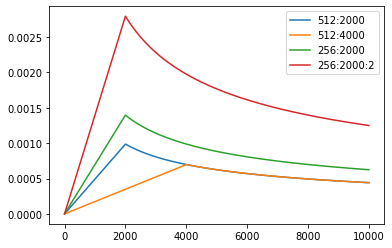

In [25]:
# Three settings of the lrate hyperparameters.
opts = [NoamScheduler(512, 1, 2000, None), 
        NoamScheduler(512, 1, 4000, None),
        NoamScheduler(256, 1, 2000, None),
        NoamScheduler(256, 2, 2000, None)]
plt.plot(np.arange(1, 10000), [[opt.rate(i) for opt in opts] for i in range(1, 10000)])
plt.legend(["512:2000", "512:4000", "256:2000", "256:2000:2"])
None

In [26]:
#optimizer = torch.optim.Adam(network.parameters(), lr=1e-4) # favourite one

N_EPOCHS = 60
total_steps = N_EPOCHS * len(train_iterator)

optimizer = torch.optim.Adam(network.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
scheduler = NoamScheduler(network.hid_dim, 0.04, len(train_iterator) * 5, optimizer)

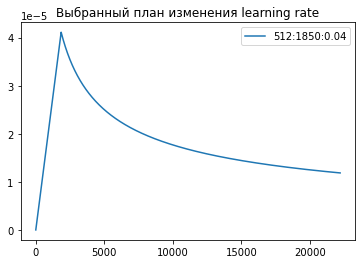

In [27]:
plt.title('Выбранный план изменения learning rate')
plt.plot(
    np.arange(1, total_steps),
    [scheduler.rate(i) for i in range(1, total_steps)],
    label=f'{scheduler.model_size}:{scheduler.warmup}:{scheduler.factor}')
plt.legend()
None

## Train it

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

In [28]:
def train(model, iterator, optimizer, criterion, clip, scheduler=None, loss_widget=None,
          train_history=None, valid_history=None, teacher_forcing_ratio=1.):
    model.train()
    
    epoch_loss = 0
    history = []
    
    bar = tqdm(enumerate(iterator), total=len(iterator))
    for i, batch in bar:
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg, teacher_forcing_ratio=teacher_forcing_ratio)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        loss = criterion(output[1:].view(-1, output.shape[-1]), trg[1:].view(-1))
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        if (scheduler is not None):
            scheduler.step()
        
        epoch_loss += loss.detach().item()
        
        history.append(loss.detach().item())
        if (i + 1) % 10 == 0 and loss_widget is not None:
            with loss_widget:
                IPython.display.clear_output(wait=True)
                fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
                ax[0].plot(history, label='train loss')
                ax[0].set_xlabel('Batch')
                ax[0].set_title('Current train loss')
                #ax[0].set_yscale('log')
                ax[1].set_title('Average losses')
                if train_history is not None:
                    ax[1].plot(train_history, label='general train history')
                    ax[1].set_xlabel('Epoch')
                if valid_history is not None:
                    ax[1].plot(valid_history, label='general valid history')
                plt.legend()
                plt.show()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing
            
            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]
            loss = criterion(output[1:].view(-1, output.shape[-1]), trg[1:].view(-1))
            
            epoch_loss += loss.detach().item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Output()

  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 01 | Time: 3m 37s
	Train Loss: 10.710 | Train PPL: 44808.054
	 Val. Loss: 24.715 |  Val. PPL: 54159489962.985


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 02 | Time: 3m 58s
	Train Loss: 5.481 | Train PPL: 240.098
	 Val. Loss: 14.877 |  Val. PPL: 2891201.009


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 03 | Time: 4m 11s
	Train Loss: 4.870 | Train PPL: 130.292
	 Val. Loss: 5.291 |  Val. PPL: 198.448


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 04 | Time: 4m 14s
	Train Loss: 4.278 | Train PPL:  72.075
	 Val. Loss: 5.061 |  Val. PPL: 157.750


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 05 | Time: 4m 25s
	Train Loss: 3.880 | Train PPL:  48.447
	 Val. Loss: 5.154 |  Val. PPL: 173.199


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 06 | Time: 4m 16s
	Train Loss: 3.626 | Train PPL:  37.559
	 Val. Loss: 5.231 |  Val. PPL: 187.025


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 07 | Time: 4m 25s
	Train Loss: 3.480 | Train PPL:  32.472
	 Val. Loss: 5.214 |  Val. PPL: 183.807


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 08 | Time: 4m 19s
	Train Loss: 3.407 | Train PPL:  30.189
	 Val. Loss: 5.267 |  Val. PPL: 193.856


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 09 | Time: 4m 10s
	Train Loss: 3.331 | Train PPL:  27.958
	 Val. Loss: 5.256 |  Val. PPL: 191.630


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 10 | Time: 4m 8s
	Train Loss: 3.297 | Train PPL:  27.045
	 Val. Loss: 5.289 |  Val. PPL: 198.147


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 11 | Time: 4m 15s
	Train Loss: 3.269 | Train PPL:  26.296
	 Val. Loss: 5.224 |  Val. PPL: 185.652


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 12 | Time: 4m 12s
	Train Loss: 3.253 | Train PPL:  25.857
	 Val. Loss: 5.205 |  Val. PPL: 182.200


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 13 | Time: 4m 6s
	Train Loss: 3.240 | Train PPL:  25.528
	 Val. Loss: 5.179 |  Val. PPL: 177.514


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 14 | Time: 4m 15s
	Train Loss: 3.226 | Train PPL:  25.185
	 Val. Loss: 5.461 |  Val. PPL: 235.418


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 15 | Time: 4m 20s
	Train Loss: 3.240 | Train PPL:  25.530
	 Val. Loss: 5.107 |  Val. PPL: 165.223


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 16 | Time: 4m 18s
	Train Loss: 3.223 | Train PPL:  25.105
	 Val. Loss: 5.111 |  Val. PPL: 165.796


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 17 | Time: 4m 13s
	Train Loss: 3.215 | Train PPL:  24.900
	 Val. Loss: 5.083 |  Val. PPL: 161.329


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 18 | Time: 4m 12s
	Train Loss: 3.215 | Train PPL:  24.903
	 Val. Loss: 5.050 |  Val. PPL: 156.067


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 19 | Time: 4m 10s
	Train Loss: 3.218 | Train PPL:  24.970
	 Val. Loss: 6.033 |  Val. PPL: 417.134


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 20 | Time: 4m 8s
	Train Loss: 3.201 | Train PPL:  24.549
	 Val. Loss: 5.002 |  Val. PPL: 148.690


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 21 | Time: 4m 13s
	Train Loss: 3.199 | Train PPL:  24.497
	 Val. Loss: 5.692 |  Val. PPL: 296.379


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 22 | Time: 4m 16s
	Train Loss: 3.201 | Train PPL:  24.545
	 Val. Loss: 4.965 |  Val. PPL: 143.347


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 23 | Time: 4m 22s
	Train Loss: 3.218 | Train PPL:  24.971
	 Val. Loss: 4.932 |  Val. PPL: 138.683


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 24 | Time: 4m 23s
	Train Loss: 3.215 | Train PPL:  24.892
	 Val. Loss: 4.919 |  Val. PPL: 136.874


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 25 | Time: 4m 17s
	Train Loss: 3.211 | Train PPL:  24.810
	 Val. Loss: 4.897 |  Val. PPL: 133.947


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 26 | Time: 4m 10s
	Train Loss: 3.202 | Train PPL:  24.574
	 Val. Loss: 4.894 |  Val. PPL: 133.537


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 27 | Time: 4m 19s
	Train Loss: 3.230 | Train PPL:  25.286
	 Val. Loss: 4.873 |  Val. PPL: 130.713


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 28 | Time: 4m 11s
	Train Loss: 3.225 | Train PPL:  25.160
	 Val. Loss: 5.563 |  Val. PPL: 260.613


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 29 | Time: 4m 14s
	Train Loss: 3.220 | Train PPL:  25.025
	 Val. Loss: 4.852 |  Val. PPL: 128.037


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 30 | Time: 4m 12s
	Train Loss: 3.236 | Train PPL:  25.439
	 Val. Loss: 4.829 |  Val. PPL: 125.120


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 31 | Time: 4m 13s
	Train Loss: 3.239 | Train PPL:  25.519
	 Val. Loss: 5.505 |  Val. PPL: 246.006


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 32 | Time: 4m 23s
	Train Loss: 3.247 | Train PPL:  25.720
	 Val. Loss: 4.770 |  Val. PPL: 117.877


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 33 | Time: 4m 15s
	Train Loss: 3.258 | Train PPL:  25.985
	 Val. Loss: 5.779 |  Val. PPL: 323.590


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 34 | Time: 4m 12s
	Train Loss: 3.254 | Train PPL:  25.904
	 Val. Loss: 4.730 |  Val. PPL: 113.307


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 35 | Time: 4m 19s
	Train Loss: 3.241 | Train PPL:  25.570
	 Val. Loss: 4.755 |  Val. PPL: 116.207


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 36 | Time: 4m 16s
	Train Loss: 3.274 | Train PPL:  26.408
	 Val. Loss: 4.698 |  Val. PPL: 109.762


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 37 | Time: 4m 19s
	Train Loss: 3.261 | Train PPL:  26.076
	 Val. Loss: 4.700 |  Val. PPL: 109.923


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 38 | Time: 4m 14s
	Train Loss: 3.275 | Train PPL:  26.447
	 Val. Loss: 4.971 |  Val. PPL: 144.213


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 39 | Time: 4m 16s
	Train Loss: 3.266 | Train PPL:  26.197
	 Val. Loss: 4.969 |  Val. PPL: 143.859


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 40 | Time: 4m 14s
	Train Loss: 3.296 | Train PPL:  27.016
	 Val. Loss: 5.346 |  Val. PPL: 209.738


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 41 | Time: 4m 15s
	Train Loss: 3.293 | Train PPL:  26.915
	 Val. Loss: 4.634 |  Val. PPL: 102.973


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 42 | Time: 4m 18s
	Train Loss: 3.297 | Train PPL:  27.042
	 Val. Loss: 4.608 |  Val. PPL: 100.260


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 43 | Time: 4m 19s
	Train Loss: 3.308 | Train PPL:  27.323
	 Val. Loss: 4.625 |  Val. PPL: 101.958


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 44 | Time: 4m 13s
	Train Loss: 3.312 | Train PPL:  27.429
	 Val. Loss: 4.590 |  Val. PPL:  98.479


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 45 | Time: 4m 10s
	Train Loss: 3.323 | Train PPL:  27.753
	 Val. Loss: 4.597 |  Val. PPL:  99.187


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 46 | Time: 4m 8s
	Train Loss: 3.331 | Train PPL:  27.964
	 Val. Loss: 4.581 |  Val. PPL:  97.618


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 47 | Time: 4m 16s
	Train Loss: 3.349 | Train PPL:  28.477
	 Val. Loss: 4.549 |  Val. PPL:  94.526


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 48 | Time: 4m 27s
	Train Loss: 3.347 | Train PPL:  28.431
	 Val. Loss: 4.541 |  Val. PPL:  93.748


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 49 | Time: 4m 17s
	Train Loss: 3.335 | Train PPL:  28.068
	 Val. Loss: 4.530 |  Val. PPL:  92.787


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 50 | Time: 4m 13s
	Train Loss: 3.341 | Train PPL:  28.246
	 Val. Loss: 4.517 |  Val. PPL:  91.583


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 51 | Time: 4m 17s
	Train Loss: 3.361 | Train PPL:  28.820
	 Val. Loss: 4.508 |  Val. PPL:  90.733


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 52 | Time: 4m 14s
	Train Loss: 3.357 | Train PPL:  28.715
	 Val. Loss: 4.509 |  Val. PPL:  90.839


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 53 | Time: 4m 18s
	Train Loss: 3.366 | Train PPL:  28.974
	 Val. Loss: 4.504 |  Val. PPL:  90.420


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 54 | Time: 4m 15s
	Train Loss: 3.382 | Train PPL:  29.417
	 Val. Loss: 4.475 |  Val. PPL:  87.752


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 55 | Time: 4m 15s
	Train Loss: 3.408 | Train PPL:  30.210
	 Val. Loss: 4.465 |  Val. PPL:  86.934


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 56 | Time: 4m 28s
	Train Loss: 3.387 | Train PPL:  29.586
	 Val. Loss: 5.136 |  Val. PPL: 170.078


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 57 | Time: 4m 31s
	Train Loss: 3.384 | Train PPL:  29.482
	 Val. Loss: 4.461 |  Val. PPL:  86.611


  0%|          | 0/370 [00:00<?, ?it/s]

Model saved
Epoch: 58 | Time: 4m 16s
	Train Loss: 3.403 | Train PPL:  30.058
	 Val. Loss: 4.423 |  Val. PPL:  83.315


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 59 | Time: 4m 11s
	Train Loss: 3.401 | Train PPL:  29.994
	 Val. Loss: 4.423 |  Val. PPL:  83.319


  0%|          | 0/370 [00:00<?, ?it/s]

Epoch: 60 | Time: 4m 7s
	Train Loss: 3.411 | Train PPL:  30.304
	 Val. Loss: 4.442 |  Val. PPL:  84.947


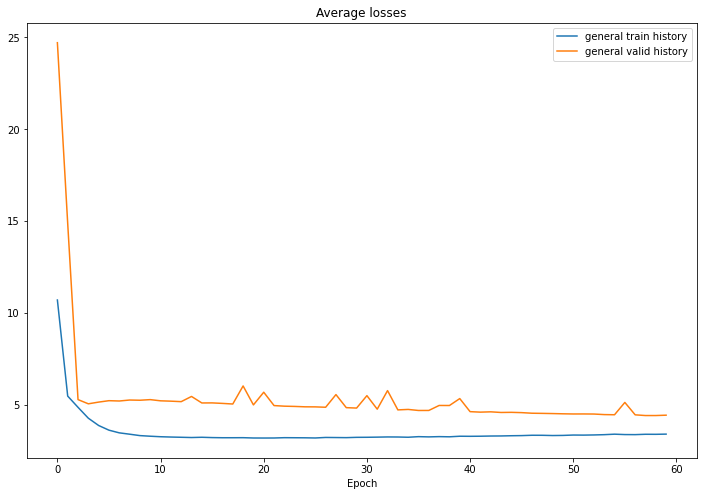

Best model loaded


In [29]:
train_history = []
valid_history = []

CLIP = 1

best_valid_loss = float('inf')
best_model = None

random_capt = True # Random label or all labels step-by-step

# Fine tuning embeddings
#make_learnable(dec.embedding, False)

loss_widget = ipywidgets.Output()
IPython.display.display(loss_widget)

for epoch in range(N_EPOCHS):
    
    torch.cuda.empty_cache()
    start_time = time.time()
    
    #if epoch == 1:
    #    make_learnable(dec.embedding, True)
    
    if epoch < 4:
        teacher_forcing_ratio = 1.
    else:
        teacher_forcing_ratio = 0.99 ** epoch
    
    if random_capt:
        TRG.set_random_mode()
    else:
        TRG.set_const_mode()
        TRG.set_epoch(epoch)
        
    train_loss = train(network, train_iterator, optimizer, loss_fn, CLIP, scheduler,
                       loss_widget, train_history, valid_history, teacher_forcing_ratio)
    
    TRG.set_const_mode()
    TRG.set_epoch(0)
    valid_loss = evaluate(network, valid_iterator, loss_fn)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        st_d = network.state_dict()
        best_model = {k: st_d[k].cpu() for k in st_d}
        print('Model saved')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_history[-1]:.3f} | Train PPL: {np.exp(train_history[-1]):7.3f}')
    print(f'\t Val. Loss: {valid_history[-1]:.3f} |  Val. PPL: {np.exp(valid_history[-1]):7.3f}')
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
ax.set_title('Average losses')
if train_history is not None:
    ax.plot(train_history, label='general train history')
    ax.set_xlabel('Epoch')
if valid_history is not None:
    ax.plot(valid_history, label='general valid history')
plt.legend()
plt.show()

if best_model is not None:
    st_d = {k: best_model[k].to(device) for k in best_model}
    network.load_state_dict(st_d)
    print('Best model loaded')
    
torch.save(network.state_dict(), 'best-model.pt')
torch.save({'train_history': train_history, 'valid_history': valid_history}, 'info.pth')

In [30]:
#network.load_state_dict(torch.load('best-model.pt'))

## Inseption и получение результатов


In [31]:
# загружаем inseption, чтобы можно было прогонять через него новые картинки, 
# получать их эмбеддинги и генерировать описания с помощью нашей сети
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

import cv2

In [32]:
def tensor2sentence(tesor):
    sentence = ''
    last_word = None
    for word in tesor:
        word = TRG.vocab.itos[word]
        if word == '<sos>' or word == '<pad>': continue
        elif word == '<eos>': break
        if last_word is None or last_word == '.':
            word = word.capitalize()
        if sentence and word != '.' and word != ',' and word != ':' and word != '?' and word != '!':
            sentence += ' '
        sentence += word
        last_word = word
    return sentence

def load_image2tensor(url):
    #sample image
    download_file(url, 'data/img.jpg')
    img = plt.imread('data/img.jpg')
    img = cv2.resize(src=img, dsize=(299, 299)).astype('float32') / 255.
    tensor = torch.tensor(img.transpose([2, 0, 1]), dtype=torch.float32)
    return tensor

### Сгенерируем описание

In [33]:
def generate_greedy_caption(image, max_len=100):
    inception.eval()
    network.eval()
    
    with torch.no_grad():
        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption = network(vectors_neck.unsqueeze(0).to(device), max_len=max_len).detach().cpu()
        caption = caption.squeeze(1).argmax(dim=1)
        caption = tensor2sentence(caption)
    
    return caption

In [34]:
def sample_possible_caption(image, max_len=100):
    assert isinstance(image, torch.FloatTensor) and image.max() <= 1 \
        and image.max() >=0 and image.shape[0] == 3
    
    n_pad = TRG.vocab.stoi['<pad>']
    n_sos = TRG.vocab.stoi['<sos>']
    n_eos=TRG.vocab.stoi['<eos>']
    
    word = n_sos

    with torch.no_grad():
        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = [word]
    
        enc_states = network.gen_enc_states(vectors_neck.to(device))
        hidden, cell = network.gen_initial_hidden_cell(vectors_neck.to(device))

    # слово за словом генерируем описание картинки
    for _ in range(max_len):
        # 1. представляем caption_prefix в виде матрицы
        # 2. Получить из RNN-ки логиты, передав ей vectors_neck и матрицу из п.1
        # 3. Перевести логиты RNN-ки в вероятности (например, с помощью F.softmax)
        # 4. сэмплировать следующее слово в описании, используя полученные вероятности. Можно сэмплировать жадно 
        # (тупо слово с самой большой вероятностью), можно сэмплировать из распределения
        # 5. Добавляем новое слово в caption_prefix
        # 6. Если RNN-ка сгенерила символ конца предложения, останавливаемся
        
        with torch.no_grad():
            prev_word = torch.LongTensor([caption_prefix[-1]]).to(device)
            output, hidden, cell = network.decoder(prev_word, hidden, cell, enc_states)

            # Получим вероятности слов
            output = torch.nn.functional.softmax(output.detach(), dim=1)

            # Получим вероятности + индексы лучших 10 слов
            values, indices = output.topk(10)

            # Установим минимальную вероятность в 2%
            values[indices == word] = 0 # Запретим повторение слов
            indices = indices[values > 0.02]
            values = values[values > 0.02]

            if values.shape[0] == 0:
                # Нет слова с вероятностью > 10%, жадно берём "самое вероятное"
                word = output.argmax(dim=1).item()
            else:
                # Выбираем случайно слово из вероятных
                word = indices[random.randint(0, indices.shape[0] - 1)].item()
            
        if word == n_pad:
            continue
            
        caption_prefix.append(word)
        
        if word == n_eos:
            break
            
    caption_prefix = tensor2sentence(torch.tensor(caption_prefix))

    return caption_prefix

### Скачаем пару картинок, чтобы проверить качество:

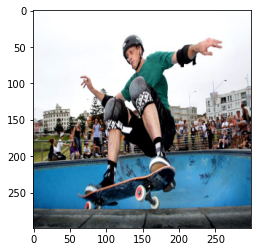

In [35]:
#sample image
img = load_image2tensor('https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg')
plt.imshow(img.permute(1, 2, 0).numpy())

In [36]:
print(f'Жадное описание: {generate_greedy_caption(img)}')
print()
print('Возможные описания из распределения:')
for i in range(10):
    print(f'{i+1}.', sample_possible_caption(img))

Жадное описание: A man riding a skateboard on a ramp.

Возможные описания из распределения:
1. A man doing tricks trick with skateboard at.
2. A man on the skateboard doing the trick
3. The young is jumping in his skateboard in front of.
4. The boy on skate boarding is on a of stairs
5. The woman jumping his trick on a trick on a ramp. A skateboard ramp.
6. The man riding his skate boarding the skate
7. The young boy is his trick off a skateboard
8. The boy is his tricks trick the skateboard in. A skate ramp
9. A boy jumping off on his skate board with a skate park
10. A male tennis jumping to hit the tennis a ramp. A tennis court.


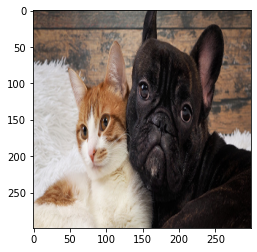

In [37]:
#sample image
img = load_image2tensor('http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg')
plt.imshow(img.permute(1, 2, 0).numpy())

In [38]:
print(f'Жадное описание: {generate_greedy_caption(img)}')
print()
print('Возможные описания из распределения:')
for i in range(10):
    print(f'{i+1}.', sample_possible_caption(img))

Жадное описание: A cat is laying on a couch with a laptop.

Возможные описания из распределения:
1. Two brown bears in each of one with one is sitting in.
2. A black cat lays a of the floor. A laptop.
3. The dog cat sitting in the of chair on to it ' s head on her feet
4. The dog and white cat lays down with the eyes. A.
5. There is an adult that has some eyes
6. Two white cats sleeping next to a pile of shoes on.
7. There is black cats are playing on together on
8. An orange cat sits next to a red bag. A chair
9. Two dogs standing around in the room.
10. An orange tabby dog wearing an animal with his tie


# Demo

ВОТ ЩАС БУИТ СМИШНО

Теперь ищите свои картинки, применяйте к ним сетку, смотрите че получится, реализовывайте вариативную часть =)

In [39]:
# apply your network on images you've found
def show_image_by_url(url):
    img = load_image2tensor(url)
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.show()
    print(f'Жадное описание: {generate_greedy_caption(img)}')
    print()
    print('Возможные описания из распределения:')
    for i in range(3):
        print(f'{i+1}.', sample_possible_caption(img))

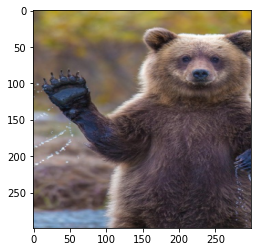

Жадное описание: A bear bear walking through a tree in a forest.

Возможные описания из распределения:
1. A bear in an open grassy in the background of.
2. An bear standing on a rock of in a water.
3. Two brown bears laying together on the ground of the road


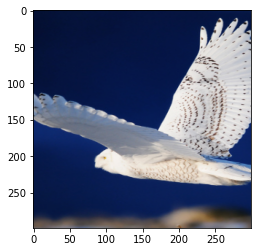

Жадное описание: A bird bird perched on a branch of a tree.

Возможные описания из распределения:
1. An owl perched up of a tree in front
2. An animal standing with the beak on it ' s mouth
3. An orange and a bird is flying the water


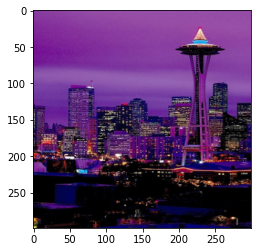

Жадное описание: A large clock tower with a city street.

Возможные описания из распределения:
1. The large are sitting over a clock of water in front of them.
2. There are two birds and the same are in a street.
3. An open clock at the water of the river.


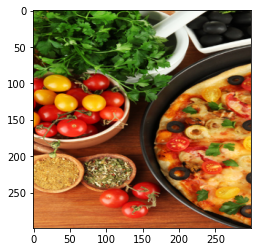

Жадное описание: A bowl of food with a and a.

Возможные описания из распределения:
1. The bowl is prepared to a with a salad. The background.
2. A plate filled with meat with broccoli on it
3. The pizza has many toppings are sitting on a stove top


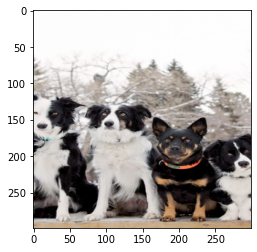

Жадное описание: A dog dog is a a frisbee in the grass.

Возможные описания из распределения:
1. Two cats standing on the snow with a. The mouth. The back.
2. An image of dog and dogs are walking in
3. Two brown and dogs in on each other with their surfboards. The water.


In [40]:
examples = [
    'https://www.anypics.ru/download.php?file=201602/320x480/anypics.ru-93418.jpg',
    'https://www.anypics.ru/download.php?file=201211/320x480/anypics.ru-33102.jpg',
    'https://www.anypics.ru/download.php?file=201211/320x480/anypics.ru-27822.jpg',
    'https://www.anypics.ru/download.php?file=201511/320x480/anypics.ru-90361.jpg',
    'https://www.anypics.ru/download.php?file=201602/320x480/anypics.ru-93223.jpg'        
]
for example in examples:
    show_image_by_url(example)

Посчитаем метрику BLEU для тестовой выборки

In [41]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

С помощью функции TRG.set_epoch() мы можем выбирать порядковый номер самописного описания. Таким образом сформируем два массива:
1. Сгенерированный на нулевой эпохе вектор предсказаний (эмбеддинг картинки -> строка описания)
2. На каждой из 5-и эпох заберём человекописные описания в качестве референса

In [42]:
hypotheses = []
references = []

network.eval()
TRG.set_const_mode()

def ids2word_list(ids):
    words = []
    for i in ids:
        word = TRG.vocab.itos[i]
        words.append(word)
        if word == '<eos>': break
    return words

for i in range(5):
    TRG.set_epoch(i)
    trg_point = 0
    for i_b, batch in enumerate(test_iterator):

        trg = batch.trg
        trg = trg.cpu().permute(1, 0).detach().numpy().tolist()
        trg = list(map(ids2word_list, trg))
        
        for t in range(len(trg)):
            if i == 0:
                references.append([trg[t]])
            else:
                references[trg_point].append(trg[t])
            trg_point += 1

        if i == 0:
            src = batch.src
            with torch.no_grad():
                output = network(src).cpu().argmax(dim=2).permute(1, 0).detach().numpy().tolist()
                output = list(map(ids2word_list, output))
                hypotheses = hypotheses + output

Проверим

In [43]:
def check_sent_i(idx):
    print('Предсказание:')
    print(hypotheses[idx])
    print()
    print('Исходные варианты:')
    for i, v in enumerate(references[idx]):
        print(f'{i+1}.', v)
        
check_sent_i(15)

Предсказание:
['<sos>', 'a', 'man', 'riding', 'a', 'skateboard', 'on', 'a', 'street', '.', '<eos>']

Исходные варианты:
1. ['<sos>', 'a', 'fireman', 'is', 'standing', 'in', 'front', 'of', 'a', 'fire', 'truck', '.', '<eos>']
2. ['<sos>', 'a', 'man', 'wearing', 'emergency', 'gear', 'and', 'a', 'helmet', '.', '<eos>']
3. ['<sos>', 'a', 'man', 'in', 'a', 'helmet', 'stands', 'in', 'front', 'of', 'a', 'fire', 'truck', '.', '<eos>']
4. ['<sos>', 'a', 'fire', 'fighter', 'walks', 'in', 'front', 'of', 'a', 'fire', 'truck', '.', '<eos>']
5. ['<sos>', 'a', 'man', 'with', 'a', 'helmet', 'walks', 'in', 'front', 'of', 'a', 'truck', '.', '<eos>']


Посчитаем BLEU

In [44]:
bleu = corpus_bleu(references, hypotheses)
print(f'BLEU = {bleu}')

BLEU = 0.27917533555120044


## Бонус: Achtung

В качестве бонусного задания предлагается реализовать механизм attention в rnn-сети, которую мы писали в базовой части.

Я скачал метаданные из оригинального датасета и сопоставил их с предобученными эмбеддингами картинок. Это делать было необязательно, но это позволило мне получить 100% соответствие мета информации и воспользоваться своим токенайзером.

Field, как источник данных для torchtext был модифицирован для наших нужд:

1. TensorField. Этот наследник умеет тензоры эмбеддингов картинок в качестве исходных данных, а на выходе отдавать загруженный на ГПУ тензор.
2. RandomField. Этот наследник умеет принимать несколько описаний и выдавать их либо в случайном порядке (используется для обучения), либо последовательно, выбирая по номеру (используется для теста) или осуществляя полный "обход" (используется для подсчёта bleu)

Благодаря этим наследникам, я смог использовать все "плюшки" torchtext в неизменном режиме, включая батчевалку, итераторы, деление на поддатасеты и др. Кроме того, я использовал предобученные вектора из FastText.

Метрика BLEU была посчитана по тестовой выборке и составила >0.27, что очень неплохо для моего количества ресурсов и "сложности" rnn.

Attention я реализовал согласно картинке ниже, приняв за входную последовательность $h_1 ... h_n$ реорганизованный эмбеддинг картинки, так чтоб он имел форму \[count of pseudo words : batch size : hidden dim\]. Таким образом, информация о исходной картинке была доступна на каждой итерации rnn'ки с коэффициентами "внимания".

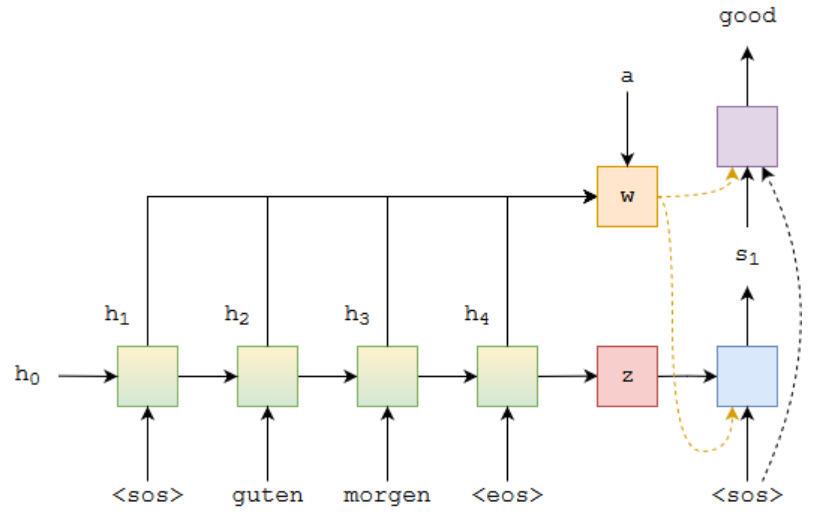

Так как прирост качества был значительный, то я выбрал такую сеть в качестве основной (реализована выше в основной части).